In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
#import czifile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import sys
#import torchvision
from torch.utils.data import Dataset, DataLoader
# from aicspylibczi import CziFile

import imageio
import time
#from cellpose import io, models

ModuleNotFoundError: No module named 'torchvision'

In [86]:
import matplotlib.animation as animation
import IPython
from IPython.display import HTML

In [ ]:
masks, flows, styles = models.CellposeModel(model_type='cyto3').eval(img_input,
                            diameter=None, channels=[0,0])

In [ ]:
plt.imshow(img[0, 50, :, :])

In [ ]:
masks.unique()

### Method 1: Manual Boxing from binary image

In [8]:
def get_bounding_boxes(a, padding = 0):
      num_rectangles = np.max(a)
      rectangle_coords = []
      for i in np.arange(num_rectangles) + 1:
        values = np.where(a == i)
        x = values[0][0]
        y = values[1][0]
        if (x!=0):
          if (padding > x):
            x = padding - x
          else:
            width = np.abs(values[0][-1] - x) + padding*2 + 1

        else:
          x = 0
          width = np.abs(values[0][-1] - x) + padding + 1



        if (y!=0):
          print(padding, "y is", y)
          if (padding > y):
            y = padding - y
          else:
            height = np.abs(values[1][-1] - y) + padding*2 +1
        else:
          y=0
          height = np.abs(values[1][-1] - y)  + padding +1

        #check that height doesnt go over the page
        if (a.shape[1]+1 < height+y):
          height  = height - (((height+y)-a.shape[1])-1)


        rectangle_coords.append((x,  width))

      return rectangle_coords





#x,y,w,h

In [9]:
def get_bounding_boxes(a, padding = 0):
  num_rectangles = np.max(a)
  rectangle_coords = []
  for i in np.arange(num_rectangles) + 1:
        values = np.where(a == i)
        x = values[0][0]
        y = values[1][0]

        #first we pick the right x value b y subtarcting padding. If the new x value is smaller than 0 then x is just 0
        x = x - padding
        width = np.abs(values[0][-1] - x) + padding + 1
        if (x < 0):
          #subtract the amounts we are removing from
          width = width - abs(x)
          x = 0

        #now we want to cut off the width if we go over
        if (x+width > a.shape[0]):
          width = width - ((x+width)-a.shape[0] )


        #repeat for y

        y = y - padding
        height = np.abs(values[1][-1] - y) + padding + 1
        if (y < 0):
          height = height - abs(y)
          y = 0
        if (y+height > a.shape[1]):
          height = height - ((y+height)-a.shape[1] )

        rectangle_coords.append((x,  width, y, height))

  return rectangle_coords








In [10]:
a = [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2],
     [1, 1, 1, 1, 0, 0, 0, 5, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2],
     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2],
     [1, 1, 1, 1, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0]]

a = np.array(a)
get_bounding_boxes(a, padding = 15)

[(0, 6, 0, 19),
 (0, 6, 0, 22),
 (0, 6, 0, 22),
 (0, 6, 0, 22),
 (0, 6, 0, 22),
 (0, 6, 5, 17)]

In [11]:
a

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 0, 0, 0, 5, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0]])

In [ ]:
def get_bounding_cube(list_of_a, padding=0):
  for a in list_of_a:
    index_coords = get_bounding_boxes(a)
    #this returns a list of [(x,y,width,height),....] for each index




### Method 2 Cellpose (too slow)

## Method 3: Skimage and thresholding

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import time
import os
import pandas as pd

In [18]:
from skimage.measure import label, regionprops_table # version at least 0.22
from skimage.filters import threshold_otsu # version at least 0.22
from utils import get_file, scale_img

In [77]:
video = get_file('mip', 3)

Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]


In [78]:
frames, shp = video.read_image(C=0)
frames = scale_img(frames.squeeze())

In [11]:
frames.shape

(90, 2048, 474)

In [28]:
def binarize_video(frames, thresh_calc='all'):
    binary_frames = []
    if (thresh_calc=='all'):
        for frame_idx, frame in enumerate(frames):
            thresh=threshold_otsu(frame)
            B = frame >= thresh
            B = label(B, background=0, connectivity=2)
            binary_frames.append(B)
            
    elif (thresh_calc == 'first'):
        # use threshhold in first frame across entire video
        thresh = threshold_otsu(frames[0])
        for frame_idx, frame in enumerate(frames):
            B = frames[frame_idx] >= thresh
            B = label(B, background=0, connectivity=2)
            binary_frames.append(B)
    
    ## func for labelling connected components
    # https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label

    return(np.array(binary_frames))

In [30]:
%%timeit
masks = binarize_video(frames)

2.24 s ± 47.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
masks.shape

(90, 2048, 474)

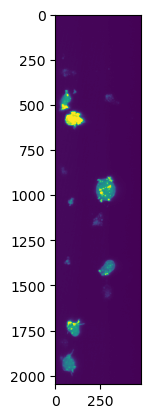

In [39]:
imshow(frames[0])

In [42]:
np.unique(masks[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int32)

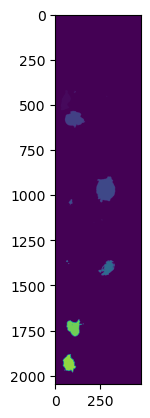

In [38]:
imshow(masks[0])

In [58]:
props = regionprops_table(label_image=masks[0],
                                  properties=['bbox','area']
        )

df = pd.DataFrame(props)
df['area'].values

array([3.6620e+03, 1.0000e+00, 1.0000e+00, 5.8000e+01, 8.0000e+00,
       1.0000e+00, 6.3670e+03, 1.0794e+04, 3.4500e+02, 9.0000e+00,
       2.0000e+00, 1.0000e+00, 3.7890e+03, 6.7000e+01, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.7000e+01, 2.0000e+00, 2.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.7000e+01,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 4.6840e+03, 1.0000e+01,
       4.3320e+03, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 7.0000e+00])

In [60]:
def bounding_boxes(mask, min_area=300):    
    # deducing centroids, max side length, 
    all_bboxes_coords = list()
    max_num_cells=0
    num_cells_frames = list()
    # region props can calculate a LOT of useful properties
    # might want to look into better cell filtering
    props = regionprops_table(label_image=mask,
                              properties=['bbox','area']
    )
    # each row corresponds to cell id, columns corresponds to properties
    # box returned as min_row, min_col, max_row, max_col
    df = pd.DataFrame(props)
    df = df[df['area'] >= min_area]
    cell_areas = df['area'].values
    df= df.drop(columns = ['area'])
    bboxes, num_cells = list(df.itertuples(index=False, name=None)), df.shape[0]
    return bboxes, num_cells, cell_areas

In [90]:
boxes, num_cells, areas = bounding_boxes(masks[1])


In [91]:
boxes

[(441, 33, 543, 90),
 (539, 55, 625, 150),
 (904, 228, 1048, 333),
 (1025, 75, 1060, 98),
 (1364, 258, 1447, 325),
 (1679, 71, 1775, 147),
 (1883, 42, 1979, 115)]

In [93]:
boxes, num_cells, areas

([(441, 33, 543, 90),
  (539, 55, 625, 150),
  (904, 228, 1048, 333),
  (1025, 75, 1060, 98),
  (1364, 258, 1447, 325),
  (1679, 71, 1775, 147),
  (1883, 42, 1979, 115)],
 7,
 array([ 3678.,  5591., 10808.,   398.,  3896.,  4522.,  4573.]))

## Visualizing Bounding Box Results

In [65]:
def draw_boxes(frame, boxes, thickness=2, val=1):
    img = frame.copy()
    for bbox in boxes:
        min_row, min_col, max_row, max_col = bbox
        img = cv2.rectangle(img, (min_col, min_row), (max_col, max_row), val, thickness)
    return(img)

In [79]:
## Putting it all together

def box_tracking_video(frames, masks=-1, thickness=2):
    if(masks == -1):
        # if not provided, calculated
        masks = binarize_video(frames)
        print("Computed binary masks")
    video = []
    num_cells_per_frame = []
    cell_areas = []
    for frame_idx in range(len(frames)):
        boxes, num_cells, areas = bounding_boxes(masks[frame_idx])
        num_cells_per_frame.append(num_cells)
        cell_areas.append(areas)

        img_with_boxes = draw_boxes(frames[frame_idx], boxes, thickness, val=1)
        video.append(img_with_boxes)
        
    return(video, num_cells_per_frame, cell_areas)
    

In [ ]:
def track_cells(frames, masks=-1, thickness=2):
    data = {"patches" : [], 'boxes' : [], "masks" : []}
    if(masks == -1):
        # if not provided, calculated
        masks = binarize_video(frames)
        print("Computed binary masks")
    for frame_idx in range(len(frames)):
        boxes, num_cells, areas = bounding_boxes(masks[frame_idx]) # all on frame
        #img_with_boxes = draw_boxes(frames[frame_idx], boxes, thickness, val=1)
        video.append(img_with_boxes)
        
    return(video, num_cells_per_frame, cell_areas)[

In [94]:
def track_cell(cell_id, frames=frames, masks=-1, padding=0):
    N = frames.shape[0]
    data = {"patches" : [], 'boxes' : [], "masks" : []}    
    if(masks == -1):
        # if not provided, calculated
        masks = binarize_video(frames)
        print("Computed binary masks")

    def get_corresponding_cell_box(boxes, num, areas, cell_prev_position=0, cell_prev_area=0):
        ## TO DO : Ensure that index of boxes stays consistent even as boxes appear and dissapear
        return(cell_id)
    
    h_max, w_max = 0, 0
    skip_frames = []
    for i in range(N):
        boxes, num_cells, areas = bounding_boxes(masks[frame_idx]) # all on frame
        index_of_cell = get_corresponding_cell_box(boxes, num_cells, areas) # right now assume same index throughout entire video
        
        bbox = boxes[index_of_cell] # cell id is meant to track a SPECIFIC cell, ensure maintain integrity of cell over time
        
        min_row, min_col, max_row, max_col = bbox

        # adjust boxes based on padding, 
        #TODO might expand boxes to homogenize sizes; 
        min_row -= padding
        min_col -= padding
        max_row += padding
        max_col += padding

        data['boxes'].append((min_row, min_col, max_row, max_col))
        
        patch = frames[i, min_row:max_row, min_col:max_col]
        mask_patch = masks[i, min_row:max_row, min_col:max_col]
        data['patches'].append(patch)
        data['masks'].append(mask_patch)

    return(data)

In [80]:
vid, cells_per_frame, areas = box_tracking_video(frames)

Computed binary masks


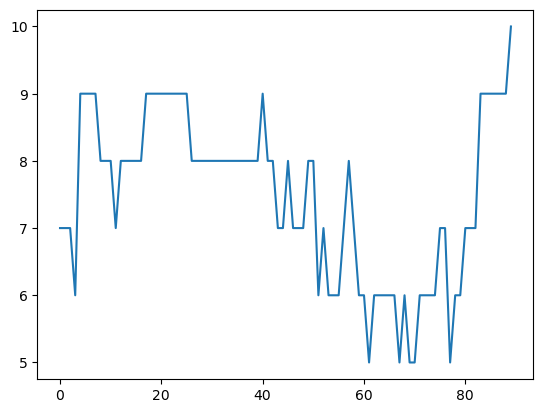

In [82]:
plt.plot(cells_per_frame)


In [83]:
vid

[array([[0.        , 0.00202566, 0.00067522, ..., 0.00810263, 0.00202566,
         0.        ],
        [0.        , 0.00607698, 0.00405132, ..., 0.        , 0.00742741,
         0.        ],
        [0.        , 0.00270088, 0.01080351, ..., 0.        , 0.0033761 ,
         0.00270088],
        ...,
        [0.        , 0.01823093, 0.00607698, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01485483, 0.01958136, ..., 0.        , 0.        ,
         0.00270088],
        [0.        , 0.02363268, 0.01417961, ..., 0.        , 0.        ,
         0.00135044]]),
 array([[0.        , 0.00810263, 0.00945307, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00472654, 0.00675219, ..., 0.        , 0.        ,
         0.00202566],
        [0.        , 0.        , 0.00810263, ..., 0.00202566, 0.        ,
         0.        ],
        ...,
        [0.        , 0.02363268, 0.01823093, ..., 0.        , 0.        ,
         0.00135044],
        [0. 

In [88]:
vid_frames = np.array(vid)

fig = plt.figure()
im = plt.imshow(vid_frames[0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(vid_frames[0])

def animate(i):
    im.set_data(vid_frames[i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=vid_frames.shape[0],
                               interval=200)

HTML(anim.to_html5_video())

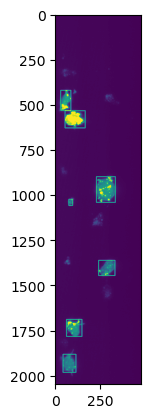

In [67]:
imshow(img)

In [ ]:
def viz_cell(frame, mask, zoom=True, thickness=3, padding=5):
    
    img = frames[frame]
    x, y, w, h = get_bounding_box(masks[frame], cell_id, padding=padding)
    img_with_box = img + cv2.rectangle(np.zeros_like(img), (x, y), (x + w, y + h), 1, thickness)
    if(zoom):
        imshow(img_with_box[y:y+h+1, x:x+w+1])
        plt.title(f"Image from x={x}:{x+w}, y={y}:{y+h}")
    else:
        imshow(img_with_box)
        plt.title(f"Box from x={x}:{x+w}, y={y}:{y+h}")

In [33]:
# returns the coords of the bounding boxes for frame in the range (first frame, last_frame-1)
# (frame, bounding boxes, box_tuple)
# format of box_tuple is 'min_row, min_col, max_row, max_col = bbox'
# min area parameter determines the smallest bounding boxes you want to output based on area 

def get_bounding_box(binary_frame, cellID, padding=3):
    binary_array = (mask == cellID)
    # Convert binary array to binary image
    binary_image = np.uint8(binary_array * 255)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if(len(contours) == 0):
        print("Contour not found")
        return(-1)
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Apply padding
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    return(x, y, x+w, y+h)




In [21]:
boxes, cells, num_cells = bounding_boxes_coords(frames)

In [25]:
len(boxes[1])

7

In [ ]:
#returns an JAGGED array of shape (num frames, num bboxes, height of image slice corresponding to bbox in frame
#                                  width of image slice corresponding to bbox in frame)
def coords_to_bbox_vid(video, bbox_coords):
    # bboxes_video = np.zeros((frames, max_num_cells, max_bbox_size, max_bbox_size))
    bboxes_video = list()
    for frame_idx, frame in enumerate(video):
        frame_list = list()
        if frame_idx >= len(bbox_coords) : continue
        for bbox in bbox_coords[frame_idx]:
            min_row, min_col, max_row, max_col = bbox
            frame_list.append(frame[min_row:max_row,min_col:max_col])
        bboxes_video.append(frame_list)


In [1]:
def track_cell(cell_id, frames=frames, masks=masks, padding=2):
    data = {"patches" : [], 'boxes' : [], "masks" : []}
    num_frames = frames.shape[0]
    h_max, w_max = 0, 0
    skip_frames = []
    for i in range(num_frames):
        box = get_bounding_box(masks[i], cell_id, padding)
        if(box != -1): # valid box
            x, y, w, h = box
            if(h > h_max):
                h_max = h
            if(w > w_max):
                w_max = w
            data['boxes'].append((x, y, w, h))
        else:
            skip_frames.append(i)
    print(f"Skipped frames {skip_frames}")
    for i, box in enumerate(data['boxes']):
        if i not in skip_frames: 
            x, y, w, h = box
            patch = frames[i, y:y+h_max, x:x+w_max]
            mask_patch = masks[i, y:y+h_max, x:x+w_max]
            data['patches'].append(patch)
            data['masks'].append(mask_patch)

    return(data)

NameError: name 'frames' is not defined